# Program ML Sistem Rekomendasi Tempat Wisata dengan Content Based Filtering

## Library yang digunakan

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Upload Dataset

In [ ]:
# Load dataset
file_path = 'WISATA.xlsx'
df = pd.read_excel(file_path, sheet_name='wisatafix')
df.head()

,Google.Maps,Name,Rating,Kategori,Review,Jalan,Harga Tiket Masuk WNI Dewasa (),Harga Tiket Masuk WNI Anak-Anak (),Harga Tiket Masuk WNA Dewasa,Harga Tiket Masuk WNA Anak-Anak,Kota/Kabupaten
0,https://www.google.com/maps/place/Upside+Down+...,Upside Down World Bali,4.2,Tourist attraction,On-site services,Jl. Bypass Ngurah Rai No.762,100000.0,50000.0,150000.0,100000.0,Denpasar
1,https://www.google.com/maps/place/Alas+Kedaton...,Alas Kedaton,4.2,Tourist attraction,"flying fox dan sepeda gantung.""","F5C4+644, Jl. Raya Alas Kedaton",20000.0,15000.0,50000.0,25000.0,Tabanan
2,https://www.google.com/maps/place/Big+Garden+C...,Big Garden Corner,4.3,Tourist attraction,NaN,"Sanur, Jl. Bypass Ngurah Rai",35000.0,35000.0,50000.0,50000.0,Denpasar
3,https://www.google.com/maps/place/Taman+Nusa/d...,Taman Nusa,4.3,Museum,NaN,"Banjar Blahpane Kelod, Jl. Taman Bali Â– Banja...",75000.0,75000.0,100000.0,100000.0,Gianyar
4,https://www.google.com/maps/place/Krisna+Funta...,Krisna Funtasticland,4.3,Tourist attraction,"""Saya benar-benar terhibur dengan berbagai","RXCV+HMR, Jl. Seririt- Singaraja",90000.0,90000.0,90000.0,90000.0,Buleleng


In [ ]:
# Pilih kolom yang digunakan
selected_columns = {
    "Name": "name",
    "Rating": "rating",
    "Kategori": "category",
    "Harga Tiket Masuk WNA Dewasa": "price_wna", # Harga yang digunakan hanya harga WNA dewasa
    "Kota/Kabupaten": "city",
    "Jalan": "address",
    "Google.Maps": "google_maps"
}
# Rename kolom
df = df.rename(columns=selected_columns)
# Pilih kolom yang telah direname
df = df[['name', 'rating', 'category', 'price_wna', 'city', 'address', 'google_maps']]
# Bersihkan data kosong dan sesuaikan tipe data
data = df.dropna(subset=["name", "rating", "category", "price_wna", "city"])
data["price_wna"] = data["price_wna"].astype(float)
data["rating"] = data["rating"].astype(float)

## Normalisasi dan encoding 4 fitur yang digunakan

In [ ]:
# Normalisasi price and rating
scaler = MinMaxScaler()
data[['price_wna', 'rating']] = scaler.fit_transform(data[['price_wna', 'rating']])

# One-hot encode untuk category and city
encoder_category = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_city = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_category = encoder_category.fit_transform(data[['category']])
encoded_city = encoder_city.fit_transform(data[['city']])

# Gabungkan 4 fitur yang dipilih
X = np.hstack((encoded_category, encoded_city, data[['price_wna', 'rating']].values))

# Dummy target untuk pelatihan
y = np.random.rand(len(X))

## Model neural network

In [ ]:
# Split dataset 80% test 20% validation
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bangun model
input_dim = train_X.shape[1] # karena ada 4 fitur maka neuron input = 4

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid') # 1 output, yaitu nilai kecocokan/relevansi tiap tempat wisata [0,1] sehingga gunakan sigmoid
])

# Definisikan metric RMSE
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# Compile model
huber_loss = Huber(delta=1.0) # gunakan huber karena netral, tidak terlalu sensitif terhadap error kecil seperti MSE dan tidak terlalu sensitif juga untuk error besar seperti MAE
model.compile(optimizer=Adam(learning_rate=0.001), loss=huber_loss, metrics=['mae', rmse])

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Berhenti setelah 10 epoch tanpa perbaikan
    restore_best_weights=True  # Kembalikan bobot terbaik
)

# Train model
history = model.fit(
    train_X, y_train,
    validation_data=(test_X, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3452 - mae: 0.2483 - rmse: 0.2936 - val_loss: 0.3224 - val_mae: 0.2503 - val_rmse: 0.2921
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3185 - mae: 0.2678 - rmse: 0.3089 - val_loss: 0.2919 - val_mae: 0.2499 - val_rmse: 0.2915
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2886 - mae: 0.2632 - rmse: 0.3032 - val_loss: 0.2643 - val_mae: 0.2493 - val_rmse: 0.2909
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2604 - mae: 0.2634 - rmse: 0.3002 - val_loss: 0.2398 - val_mae: 0.2494 - val_rmse: 0.2908
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2348 - mae: 0.2535 - rmse: 0.2921 - val_loss: 0.2177 - val_mae: 0.2490 - val_rmse: 0.2905
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2166 - mae: 0.2670 - rmse: 0.3015 - val_loss: 0.1977 - val_mae: 0.2486 - val_rmse: 0.2902
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1900 - mae: 0.2410 - rmse: 0.279

In [ ]:
# Display summary model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 20)                  │             360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,745 (6.82 KB)

 Trainable params: 581 (2.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,164 (4.55 KB)

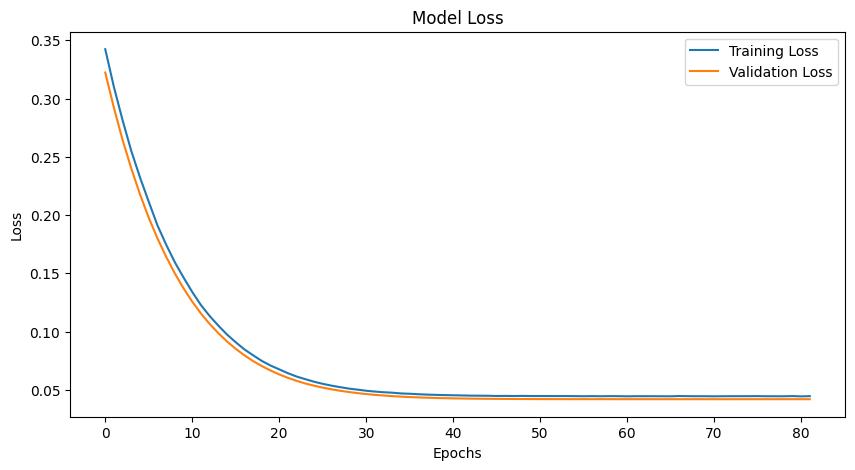

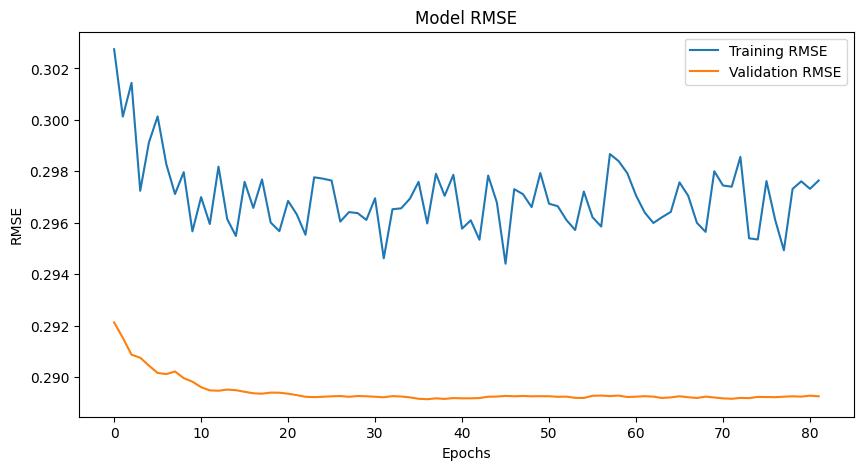

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation RMSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Model RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Fungsi untuk preproses input dan menampilkan output rekomendasi berdasarkan filter

In [ ]:
# fungsi untuk mengolah input agar format sesuai dengan model
def preprocess_user_input(user_input):
    # Buat DataFrame dari input pengguna
    user_df = pd.DataFrame([{
        "price_wna": user_input["max_price"],
        "rating": user_input["min_rating"]
    }])

    # Normalisasi input pengguna menggunakan scaler
    normalized_input = scaler.transform(user_df)

    # Encode kategori dan kota
    user_category = encoder_category.transform([[user_input['category']]])
    user_city = encoder_city.transform([[user_input['city']]])

    # Gabungkan semua fitur
    user_vector = np.hstack((user_category, user_city, normalized_input))

    return user_vector


In [ ]:
# fungsi untuk menampilkan top 5 rekomendasi berdasarkan input user
def recommend(user_input, top_n=5):
    # Preproses input pengguna
    user_input_vector = preprocess_user_input(user_input)

    # Prediksi score untuk masing-masing data
    scores = model.predict(X)
    data['score'] = scores.flatten()

    # Normalisasi nilai filter dari input pengguna
    user_df = pd.DataFrame([{
        "price_wna": user_input["max_price"],
        "rating": user_input["min_rating"]
    }])
    normalized_input = scaler.transform(user_df)
    max_price_scaled, min_rating_scaled = normalized_input[0]

    # Filter data berdasarkan kriteria pengguna
    # Cek apakah kolom 'address' dan 'google_maps' ada sebelum difilter
    if 'address' in data.columns and 'google_maps' in data.columns:
        filtered_data = data[
            (data['rating'] >= min_rating_scaled) &
            (data['price_wna'] <= max_price_scaled) &
            (data['city'] == user_input['city']) &  # Filter berdasarkan kota
            (data['category'] == user_input['category']) & # Filter berdasarkan kategori
            (data['address'].notna()) & (data['google_maps'].notna())  # Filter data kosong
        ]
    else:
        # Jika kolom tidak ada, tampilkan warning
        print("Warning: 'address' or 'google_maps' column not found in data. Filtering without them.")
        filtered_data = data[
            (data['rating'] >= min_rating_scaled) &
            (data['price_wna'] <= max_price_scaled) &
            (data['city'] == user_input['city']) &  # Filter berdasarkan kota
            (data['category'] == user_input['category']) # Filter berdasarkan kategori
        ]


    # Kembalikan nilai rating dan price_wna ke skala asli
    if not filtered_data.empty:
        filtered_data.loc[:, ['price_wna', 'rating']] = scaler.inverse_transform(
            filtered_data[['price_wna', 'rating']]
        )

    # Ambil rekomendasi top-N
    if not filtered_data.empty:
        recommendations = filtered_data.nlargest(top_n, 'score')
    else:
        print("No recommendations found based on the given criteria.")
        recommendations = pd.DataFrame()  # DataFrame kosong jika tidak ada rekomendasi

    # Cek jika required columns ada di recommendations
    required_columns = ['name', 'rating', 'price_wna', 'city', 'category', 'address', 'google_maps']
    available_columns = recommendations.columns.tolist()

    # Pilih kolom yang ada saja
    selected_columns = [col for col in required_columns if col in available_columns]

    return recommendations[selected_columns]

## Penggunaan input untuk rekomendasi berdasarkan filter

In [ ]:
# Input dari pengguna
user_input = {
    "category": input("Enter the category of destination (Beach/Tourist attraction/Museum): "),       # Contoh: "Beach"
    "city": input("Enter the city you want to go to : "),            # Contoh: "Denpasar"
    "min_rating": float(input("Enter the minimum rating (0.0-5.0): ")),  # Contoh: 4.0
    "max_price": float(input("Enter the maximum ticket price (IDR) : "))  # Contoh: 50000
}

# Tampilkan rekomendasi
top_5_recommendations1 = recommend(user_input)
print(top_5_recommendations1)

Enter the category of destination (Beach/Tourist attraction/Museum): Tourist attraction
Enter the city you want to go to : Badung
Enter the minimum rating (0.0-5.0): 4.5
Enter the maximum ticket price (IDR) : 40000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                                    name  rating     price_wna    city  \
27                              5GX Bali     4.7  34473.856209  Badung   
28   Pandora Experience Escape Room Bali     4.7  34473.856209  Badung   
128                          Geger Beach     4.7  34473.856209  Badung   
131                      Cemongkak Beach     4.7  34473.856209  Badung   
194    Sorrento Mediterranean Restaurant     4.7  34473.856209  Badung   

               category                           address  \
27   Tourist attraction  Jalan Legian No.99, Legian, Kuta   
28   Tourist attraction              Jl. Dewi Sri No.45 D   
128  Tourist attraction                          56MG+RFQ   
131  Tourist attraction                                Â·   
194  Tourist attraction          ITDC Lot 1, Jl. Nusa Dua   

                                           google_maps  
27   https://www.google.com/maps/place/5GX+Bali/dat...  
28   https://www.google.com/maps/p

## Fungsi untuk rekomendasi berdasarkan wisata yang sebelumnya dikunjungi

In [ ]:
# fungsi untuk rekomendasi berdasarkan wisata yang telah dikunjungi
def recommend_similar_wisata(wisata_name, city_filter=None, max_price=None, top_n=5):
    # Pastikan nama tempat wisata ada dalam data
    if wisata_name not in data['name'].values:
        print(f"Tempat wisata '{wisata_name}' tidak ditemukan dalam data.")
        return pd.DataFrame()

    # Pilih fitur yang digunakan untuk perhitungan similarity
    features = np.hstack((
        encoded_category,
        encoded_city,
        data[['price_wna', 'rating']].values
    ))

    # Ambil indeks tempat wisata yang diminta
    wisata_idx = data[data['name'] == wisata_name].index[0]

    # Hitung kesamaan menggunakan cosine similarity antara tempat wisata input dengan semua tempat wisata lainnya
    similarity_scores = cosine_similarity(features[wisata_idx].reshape(1, -1), features).flatten()

    # Tambahkan skor kesamaan ke dalam DataFrame
    data['similarity'] = similarity_scores

    # Ubah tipe data max_price ke float jika tidak kosong
    if max_price is not None:
        max_price = float(max_price)

    # Filter data jika ada city_filter atau max_price
    filtered_data = data[data['name'] != wisata_name]
    if city_filter:
        filtered_data = filtered_data[filtered_data['city'] == city_filter]
    if max_price is not None:
        # Normalisasi max_price untuk filter
        max_price_scaled = scaler.transform([[max_price, 0]])[0][0]
        filtered_data = filtered_data[filtered_data['price_wna'] <= max_price_scaled]

    # Kembalikan nilai rating dan price_wna ke skala aslinya
    if not filtered_data.empty:
        filtered_data.loc[:, ['price_wna', 'rating']] = scaler.inverse_transform(
            filtered_data[['price_wna', 'rating']]
        )

    # Urutkan berdasarkan skor similarity (descending) dan ambil top-N
    recommendations = filtered_data.nlargest(top_n, 'similarity') if not filtered_data.empty else pd.DataFrame()

    # Pilih kolom untuk ditampilkan
    return recommendations[['name', 'rating', 'price_wna', 'city', 'category', 'address', 'google_maps', 'similarity']]


## Penggunaan input rekomendasi berdasarkan wisata yang sebelumnya dikunjungi

In [ ]:
# input dari user
wisata_name = input("Enter the name of destination you have already visited : ")
city_filter = input("Enter the city you want to go to (optional): ") or None
max_price = input("Enter the maximum ticket price (optional): ") or None

# output
top_5_recommendations = recommend_similar_wisata(wisata_name, city_filter=city_filter, max_price=max_price)
print(top_5_recommendations)

Enter the name of destination you have already visited : 5GX Bali
Enter the city you want to go to (optional): 
Enter the maximum ticket price (optional): 30000
                            name  rating  price_wna    city  \
16           Objek Wisata Sangeh     4.6    30000.0  Badung   
271              Kutuh waterfall     4.6    30000.0  Badung   
272           Nungnung Waterfall     4.7    20000.0  Badung   
26           Pantai Double - Six     4.7        0.0  Badung   
238  Jembong Waterfall, Ambengan     4.5    10000.0  Badung   

               category       address  \
16   Tourist attraction  Jl. Brahmana   
271  Tourist attraction      R8P9+9Q3   
272  Tourist attraction           NaN   
26   Tourist attraction           NaN   
238  Tourist attraction           NaN   

                                           google_maps  similarity  
16   https://www.google.com/maps/place/Objek+Wisata...    0.999915  
271  https://www.google.com/maps/place/Kutuh+waterf...    0.999915  
272  h

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
